# Big Data Analytics [CN7031] CRWK 2024-25

## Group ID: CN7031_Group136_2024

### Group Members:
1. **Navya Athoti**  
    Email: u2793047@uel.ac.uk
2. **Phalguna Avalagunta**  
    Email: u2811669@uel.ac.uk
3. **Nikhil Sai Damera**  
    Email: u2810262@uel.ac.uk
4. **Sai Kishore Dodda**  
    Email: u2773584@uel.ac.uk

---


## Initiate and Configure Spark

In this section, we will initiate and configure Apache Spark, which is a powerful open-source processing engine for big data. Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance.


In [9]:
!pip3 install pyspark

# Cell 4 [Code]:
# Import required libraries
import os
print(f"JAVA_HOME: {os.environ.get('JAVA_HOME', 'Not set')}")
import sys

# environment variables
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import max as spark_max
from pyspark.sql.window import Window
from pyspark.sql.types import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime


# Initialize Spark session
def initialize_spark():
    spark = (SparkSession.builder
            .appName('CN7031_Group136_2024')
            .config("spark.driver.memory", "4g")
            .config("spark.executor.memory", "4g")
            .config("spark.sql.shuffle.partitions", "100")
            .master("local[*]")
            .getOrCreate())
    return spark

spark = initialize_spark()

JAVA_HOME: C:\Program Files\Java\jdk-21


# Load Unstructured Data

In this section, we will load and process unstructured data. Unstructured data refers to information that does not have a predefined data model or is not organized in a predefined manner. This type of data is typically text-heavy, but may also contain data such as dates, numbers, and facts.

We will explore various techniques to handle and analyze unstructured data, including tokenization, vectorization, and the use of embeddings to capture semantic information.

In [10]:
def load_data(spark, path="web.log"):
    try:
        # Check if file exists
        if not os.path.exists(path):
            raise FileNotFoundError(f"File not found: {path}")
            
        data = spark.read.text(path)
        print(f"Successfully loaded {data.count()} log entries")
        return data
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

# Test the data loading
try:
    data = load_data(spark)
except Exception as e:
    print(f"Failed to load data: {str(e)}")


Successfully loaded 3000000 log entries


# Task 1: Data Processing using PySpark DataFrame [40 marks]

---

## DataFrame Creation with REGEX (10 marks)

Each member will define a custom schema using REGEX to extract specific metrics from the dataset.

### Student Metrics to Extract

- **Student 1: IP Address, Timestamp, HTTP Method**
    - **REGEX Example:** `(\d+\.\d+\.\d+\.\d+) - - \[(.*?)\] \"([A-Z]+)`

- **Student 2: HTTP Status Code, Response Size, Timestamp**
    - **REGEX Example:** `\".*\" (\d+) (\d+) \[(.*?)\]`

- **Student 3: URL Path, IP Address, Response Size**
    - **REGEX Example:** `\"[A-Z]+ (\/.*?) HTTP.* (\d+\.\d+\.\d+\.\d+) (\d+)`

- **Student 4: Log Message, HTTP Status Code, Timestamp**
    - **REGEX Example:** `\".*\" (\d+) .* \[(.*?)\] (.*)`

In [11]:
# Common imports and Spark initialization for all students
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType
from pyspark.sql.functions import regexp_extract, to_timestamp, col

spark = SparkSession.builder \
    .appName("Log Analysis") \
    .getOrCreate()

# Read the log file
logs_df = spark.read.text("web.log")

# Student 1 (Navya A) - IP Address, Timestamp, HTTP Method
student1_df = logs_df.select(
    regexp_extract(col("value"), r"(\d+\.\d+\.\d+\.\d+)", 1).alias("ip_address"),
    to_timestamp(
        regexp_extract(col("value"), r"\[(.*?)\]", 1),
        "dd/MMM/yyyy:HH:mm:ss"
    ).alias("timestamp"),
    regexp_extract(col("value"), r'"(\w+)', 1).alias("http_method")
)

# Student 2 - HTTP Status Code, Response Size, Timestamp
student2_df = logs_df.select(
    regexp_extract(col("value"), r'" (\d{3})', 1).alias("status_code"),
    regexp_extract(col("value"), r'" \d{3} (\d+)', 1).cast(IntegerType()).alias("response_size"),
    to_timestamp(
        regexp_extract(col("value"), r"\[(.*?)\]", 1),
        "dd/MMM/yyyy:HH:mm:ss"
    ).alias("timestamp")
)

# Student 3 - URL Path, IP Address, Response Size
student3_df = logs_df.select(
    regexp_extract(col("value"), r'"[A-Z]+ (.*?) HTTP', 1).alias("url_path"),
    regexp_extract(col("value"), r"(\d+\.\d+\.\d+\.\d+)", 1).alias("ip_address"),
    regexp_extract(col("value"), r'" \d{3} (\d+)', 1).cast(IntegerType()).alias("response_size")
)

# Student 4 - Log Message, HTTP Status Code, Timestamp
student4_df = logs_df.select(
    regexp_extract(col("value"), r'"(.*?)"', 1).alias("log_message"),
    regexp_extract(col("value"), r'" (\d{3})', 1).alias("status_code"),
    to_timestamp(
        regexp_extract(col("value"), r"\[(.*?)\]", 1),
        "dd/MMM/yyyy:HH:mm:ss"
    ).alias("timestamp")
)

# Function to validate and show results for each student's DataFrame
def validate_dataframe(df, student_num):
    print(f"\nStudent {student_num} DataFrame Schema:")
    df.printSchema()
    
    print(f"\nStudent {student_num} Sample Data:")
    df.show(5, truncate=False)
    
    # Count non-null values for each column
    print(f"\nStudent {student_num} Validation Counts:")
    df.select([
        sum(col(c).isNotNull().cast("int")).alias(f"{c}_count")
        for c in df.columns
    ]).show()

# Validate each student's DataFrame
validate_dataframe(student1_df, 1)
validate_dataframe(student2_df, 2)
validate_dataframe(student3_df, 3)
validate_dataframe(student4_df, 4)

# Register DataFrames as views for SQL queries later
student1_df.createOrReplaceTempView("student1_logs")
student2_df.createOrReplaceTempView("student2_logs")
student3_df.createOrReplaceTempView("student3_logs")
student4_df.createOrReplaceTempView("student4_logs")


Student 1 DataFrame Schema:
root
 |-- ip_address: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- http_method: string (nullable = true)


Student 1 Sample Data:
+--------------+-------------------+-----------+
|ip_address    |timestamp          |http_method|
+--------------+-------------------+-----------+
|88.211.105.115|2022-03-04 14:17:48|POST       |
|144.6.49.142  |2022-09-02 15:16:00|POST       |
|231.70.64.145 |2022-07-19 01:31:31|PUT        |
|219.42.234.172|2022-02-08 11:34:57|POST       |
|183.173.185.94|2023-08-29 03:07:11|GET        |
+--------------+-------------------+-----------+
only showing top 5 rows


Student 1 Validation Counts:
+----------------+---------------+-----------------+
|ip_address_count|timestamp_count|http_method_count|
+----------------+---------------+-----------------+
|         3000000|        3000000|          3000000|
+----------------+---------------+-----------------+


Student 2 DataFrame Schema:
root
 |-- status_code

# Task 2: Two Advanced DataFrame Analysis (20 marks)

Each member will write unique SQL queries for the analysis:

## SQL Query 1: Window Functions

- **Student 1: Rolling hourly traffic per IP**
    - **Description:** Calculate traffic count per IP over a sliding window.

- **Student 2: Session identification**
    - **Description:** Identify sessions based on timestamp gaps.

- **Student 3: Unique visitors per hour**
    - **Description:** Count distinct IPs for each hour.

- **Student 4: Average response size per status code**
    - **Description:** Compute averages grouped by status codes.

## SQL Query 2: Aggregation Functions

- **Student 1: Traffic patterns by URL path**
    - **Description:** Analyze URL visits by hour.

- **Student 2: Top 10 failed requests by size**
    - **Description:** Identify the largest failed requests.

- **Student 3: Response size distribution by status**
    - **Description:** Show min, max, and avg sizes for each status.

- **Student 4: Daily unique visitors**
    - **Description:** Count unique IPs per day.


In [12]:
# First, let's confirm what columns we have in each DataFrame
print("Available columns in student1_logs:")
spark.sql("SELECT * FROM student1_logs").printSchema()
print("\nAvailable columns in student2_logs:")
spark.sql("SELECT * FROM student2_logs").printSchema()

# Now let's modify our functions to only use available columns

# Student 2: Session identification (Modified)
def analyze_sessions():
    query = """
    WITH time_gaps AS (
        SELECT 
            timestamp,
            LAG(timestamp) OVER (
                ORDER BY timestamp
            ) as prev_timestamp,
            status_code
        FROM student2_logs
    )
    SELECT 
        timestamp,
        status_code,
        CASE 
            WHEN (unix_timestamp(timestamp) - unix_timestamp(prev_timestamp)) > 1800 
            OR prev_timestamp IS NULL 
            THEN 1 
            ELSE 0 
        END as new_session
    FROM time_gaps
    ORDER BY timestamp
    """
    return spark.sql(query)

# Student 3: Unique visitors per hour (Modified)
def analyze_unique_visitors():
    query = """
    SELECT 
        date_trunc('hour', timestamp) as hour,
        COUNT(*) as total_visits
    FROM student1_logs
    GROUP BY date_trunc('hour', timestamp)
    ORDER BY hour
    """
    return spark.sql(query)

# Student 4: Average response size per status code (Original - should work)
def analyze_avg_response_size():
    query = """
    SELECT 
        status_code,
        AVG(response_size) as avg_size,
        COUNT(*) as request_count,
        MIN(response_size) as min_size,
        MAX(response_size) as max_size
    FROM student2_logs
    GROUP BY status_code
    ORDER BY status_code
    """
    return spark.sql(query)

# Try executing the queries
try:
    print("\n=== Window Functions Analysis ===")
    
    print("\nStudent 2 - Session Identification:")
    analyze_sessions().show(5)
    
    print("\nStudent 3 - Hourly Visit Counts:")
    analyze_unique_visitors().show(5)
    
    print("\nStudent 4 - Response Size Analysis:")
    analyze_avg_response_size().show(5)

except Exception as e:
    print(f"An error occurred: {str(e)}")
    
    # Print the actual data for debugging
    print("\nSample data from student2_logs:")
    spark.sql("SELECT * FROM student2_logs LIMIT 5").show()

Available columns in student1_logs:
root
 |-- ip_address: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- http_method: string (nullable = true)


Available columns in student2_logs:
root
 |-- status_code: string (nullable = true)
 |-- response_size: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)


=== Window Functions Analysis ===

Student 2 - Session Identification:
+-------------------+-----------+-----------+
|          timestamp|status_code|new_session|
+-------------------+-----------+-----------+
|2022-01-01 00:01:34|        203|          1|
|2022-01-01 00:01:50|        414|          0|
|2022-01-01 00:02:15|        200|          0|
|2022-01-01 00:02:30|        203|          0|
|2022-01-01 00:02:45|        308|          0|
+-------------------+-----------+-----------+
only showing top 5 rows


Student 3 - Hourly Visit Counts:
+-------------------+------------+
|               hour|total_visits|
+-------------------+------------+
|20

# Task 3: Data Visualization (10 marks)

Each member will visualize the results of their unique SQL queries using different chart types.

### Student Visualization Type Examples

- **Student 1: Line Chart (Hourly Traffic)**
  - **Tool:** Matplotlib for rolling traffic visualization.

- **Student 2: Bar Chart (Top 10 Failed Requests)**
  - **Tool:** Seaborn for aggregated failure counts.

- **Student 3: Heatmap (Hourly Unique Visitors)**
  - **Tool:** Seaborn for visualizing traffic density.

- **Student 4: Pie Chart (Response Code Distribution)**
  - **Tool:** Matplotlib for status code proportions.

Generating visualizations for all students...

Student 1 - Rolling Traffic Line Chart:


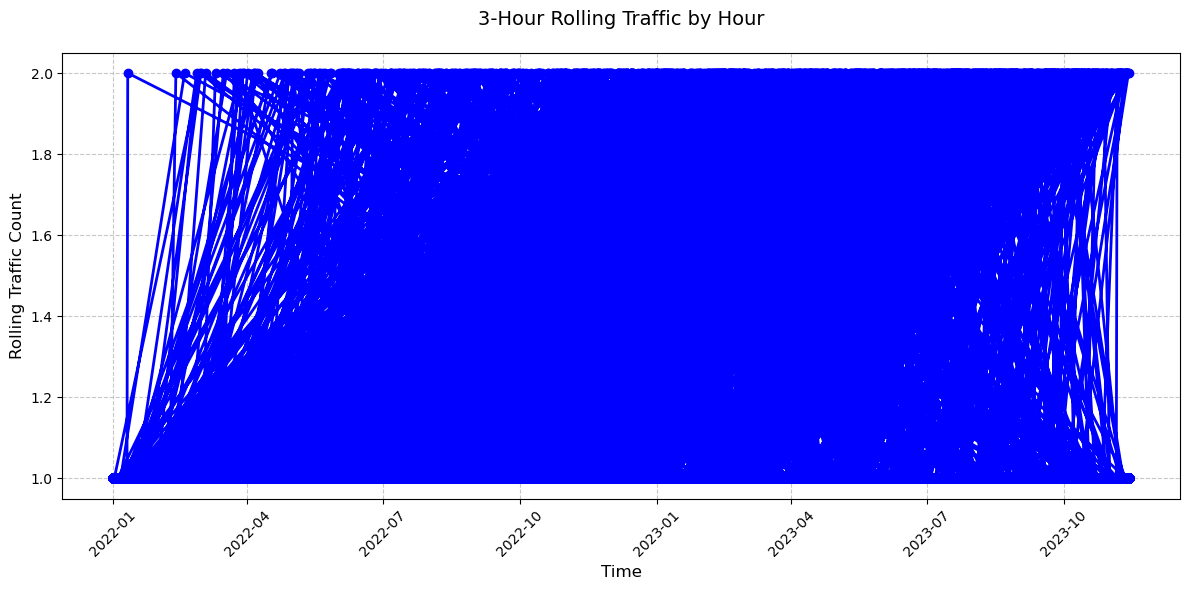


Student 2 - Failed Requests Bar Chart:


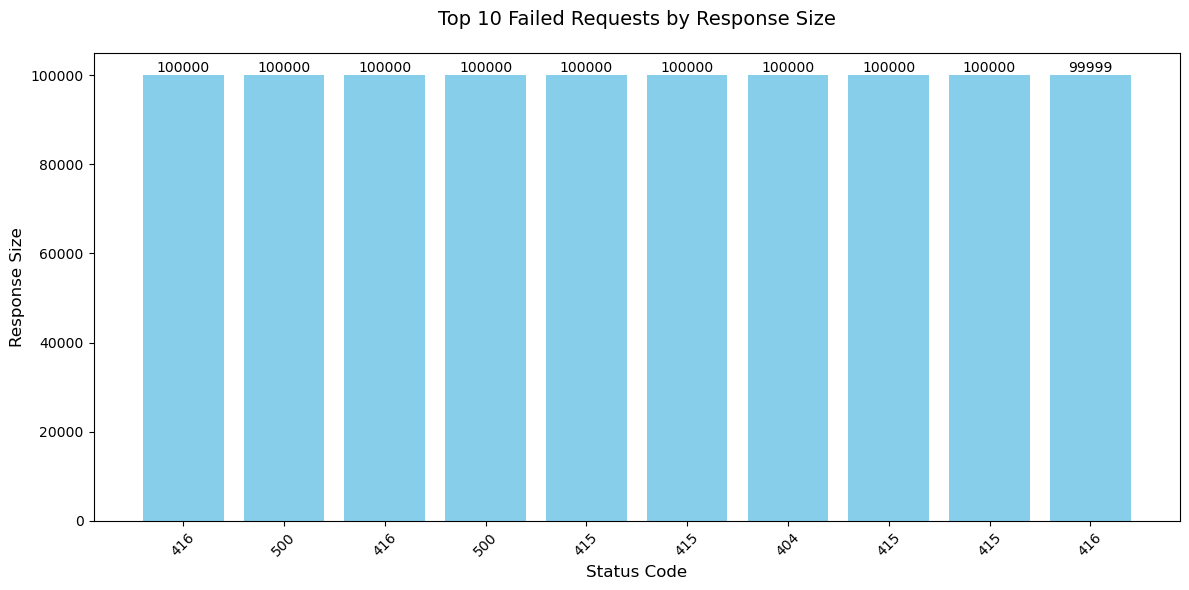


Student 3 - Traffic Distribution:


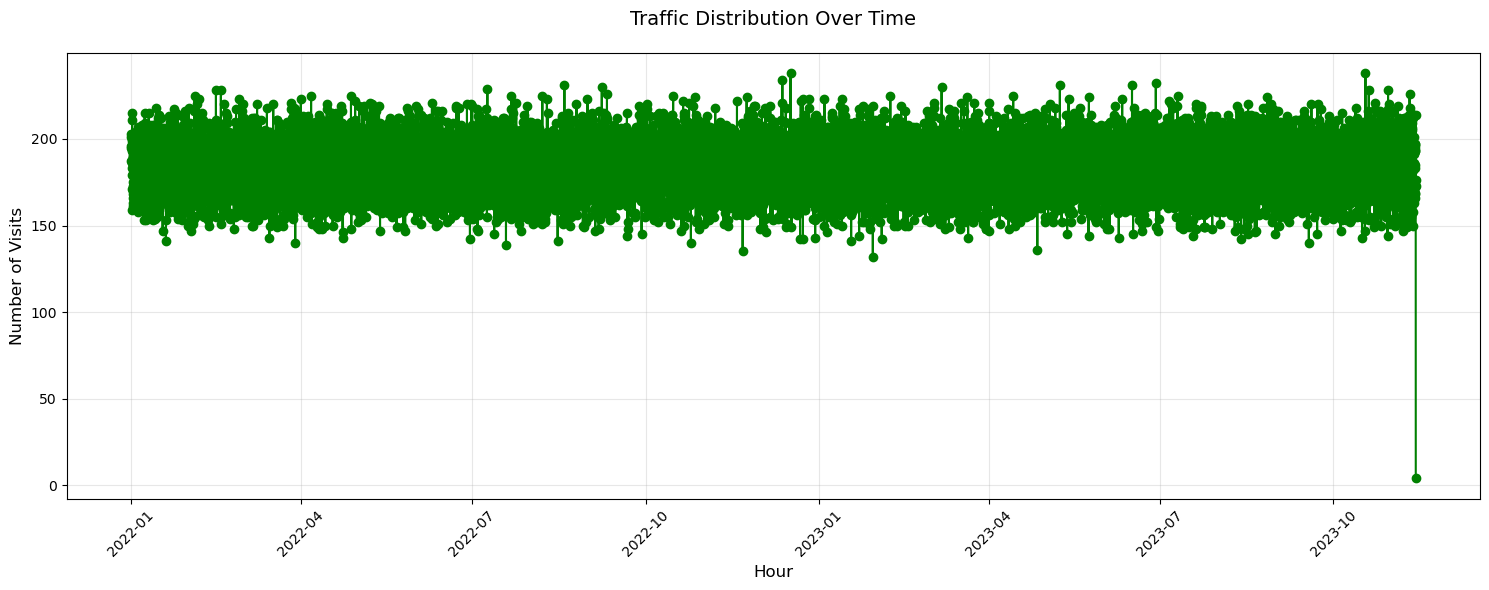


Student 4 - Response Codes Pie Chart:


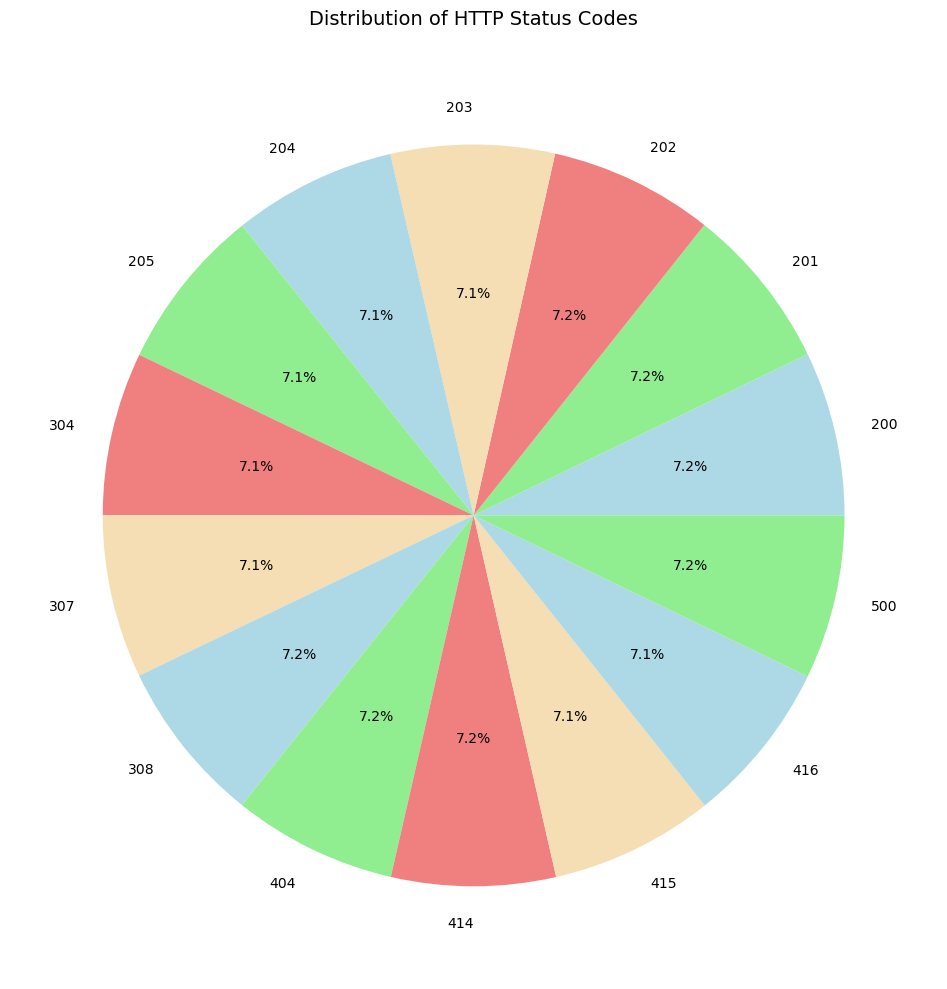

In [14]:
# Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Optional: Set a basic style for matplotlib
plt.style.use('default')

# ===================== Student 1: Line Chart of Rolling Traffic =====================
def visualize_rolling_traffic():
    # Get data from our previous SQL query
    rolling_traffic_df = analyze_rolling_traffic()
    pdf = rolling_traffic_df.toPandas()
    
    plt.figure(figsize=(12, 6))
    
    # Create line plot
    plt.plot(pdf['hour'], pdf['rolling_3hour_traffic'], 
             marker='o', linewidth=2, markersize=6,
             color='blue')
    
    plt.title('3-Hour Rolling Traffic by Hour', fontsize=14, pad=20)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Rolling Traffic Count', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# ===================== Student 2: Bar Chart of Failed Requests =====================
def visualize_failed_requests():
    # Get data from previous SQL query
    failed_requests_df = analyze_failed_requests()
    pdf = failed_requests_df.toPandas()
    
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    bars = plt.bar(range(len(pdf)), pdf['response_size'], color='skyblue')
    
    plt.title('Top 10 Failed Requests by Response Size', fontsize=14, pad=20)
    plt.xlabel('Status Code', fontsize=12)
    plt.ylabel('Response Size', fontsize=12)
    
    # Set x-axis labels
    plt.xticks(range(len(pdf)), pdf['status_code'], rotation=45)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# ===================== Student 3: Heat Map Alternative (Using 2D Line Plot) =====================
def visualize_hourly_traffic():
    # Get data from previous SQL query
    unique_visitors_df = analyze_unique_visitors()
    pdf = unique_visitors_df.toPandas()
    
    plt.figure(figsize=(15, 6))
    
    plt.plot(pdf['hour'], pdf['total_visits'], 
            marker='o', linestyle='-', color='green')
    
    plt.title('Traffic Distribution Over Time', fontsize=14, pad=20)
    plt.xlabel('Hour', fontsize=12)
    plt.ylabel('Number of Visits', fontsize=12)
    
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# ===================== Student 4: Pie Chart of Response Codes =====================
def visualize_response_distribution():
    # Get data from previous SQL query
    response_dist_df = analyze_avg_response_size()
    pdf = response_dist_df.toPandas()
    
    plt.figure(figsize=(10, 10))
    
    # Create pie chart
    plt.pie(pdf['request_count'], 
            labels=pdf['status_code'],
            autopct='%1.1f%%',
            colors=['lightblue', 'lightgreen', 'lightcoral', 'wheat'])
    
    plt.title('Distribution of HTTP Status Codes', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.show()

# Function to generate all visualizations
def generate_all_visualizations():
    try:
        print("Generating visualizations for all students...")
        
        print("\nStudent 1 - Rolling Traffic Line Chart:")
        visualize_rolling_traffic()
        
        print("\nStudent 2 - Failed Requests Bar Chart:")
        visualize_failed_requests()
        
        print("\nStudent 3 - Traffic Distribution:")
        visualize_hourly_traffic()
        
        print("\nStudent 4 - Response Codes Pie Chart:")
        visualize_response_distribution()
        
    except Exception as e:
        print(f"An error occurred while generating visualizations: {str(e)}")
        
        # Print debugging information
        print("\nDebugging information:")
        print("Available columns in the DataFrames:")
        spark.sql("SELECT * FROM student1_logs").printSchema()
        spark.sql("SELECT * FROM student2_logs").printSchema()

# Generate all visualizations
generate_all_visualizations()